In [1]:
# Imports

from scipy import stats 
import numpy as np
import math
from math import e
from math import factorial
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
dados = pd.read_excel('carros.xlsx')

----
### Filtragem de Colunas e Marcas

In [2]:
# REMOVENDO COLUNAS QUE FORAM JULGADAS DESNECESSARIAS
dados.drop(["seller_type", "no_of_cylinders", "regional_specs", "steering_side", "color", "emirate","motors_trim","model"], axis=1, inplace=True)


# FILTRANDO AS MARCAS QUE SERAM UTILIZADAS
# marcas = ['nissan', 'audi', 'mercedes-benz', 'lamborghini', 'maserati', 'bmw', 'bentley','ferrari']
marcas = ['ford', 'chevrolet', 'fiat', 'honda'] # Já que as outras marcas deixavam nossos preços com uma variedade gigantesca, optamos por mudar para marcas com preços mais padronizados
dados = dados.loc[dados.company.isin(marcas),:]


# DEFININDO VARIAVEIS
preco = dados['price_in_aed'].apply(lambda x: float(x.replace(".","").replace(",","")))

dados['price_in_aed'] = preco
marca = dados['company']
condicao = dados['body_condition']
tipo = dados['body_type']
transmissao = dados['transmission_type']
cavalos = dados['horsepower']
ano = dados['year']
km = dados['kilometers']
combustivel = dados['fuel_type']


# Por conta de alguns casos particulares, usamos esse filtro para padronizar os valores
dados = dados.loc[dados['kilometers']<400000,:] # tirar os casos de carros com quilometragens absurdas
dados = dados.loc[dados['price_in_aed']<1099000,:] # tinha 1 carro que era muito mais caro que todos os outros

Após a filtragem de marcas e colunas, iremos utilizar a planilha de dados com um total de 12 colunas e 3956 linhas, que inicialmente possuía 20 colunas e 9970 linhas.
As colunas são: 
* Title
* Price in aed
* Kilometers
* Body Condition
* Mechanical Condition 
* Body Type
* Transmission Type
* Horsepower
* Fuel Type

E as marcas:
* Nissan
* Audi
* Mercedes
* Lamborghini
* Maserati
* Bmw
* Bentley
* Ferrari

----
## Definindo faixas de preços
##### Já que nossa base de dados tem VARIOS preços, ao utilizar faixas de preço ao invés de um por um, podemos facilitar o processo

In [3]:
faixas = np.linspace(5000,2000000,100)

dados['precoFaixa'] = pd.cut(preco, bins=faixas)

# dados['precoFaixa']

----
## Vendo as correlações

In [4]:
print(preco.corr(km)) # quanto menor a quilometragem menor o preco
print(preco.corr(ano)) # quanto mais novo o carro maior o preco
dados.corr()

-0.3348467477894393
0.18863883292534722


,price_in_aed,kilometers,year
price_in_aed,1.000000,-0.547807,0.273474
kilometers,-0.547807,1.000000,-0.345580
year,0.273474,-0.345580,1.000000


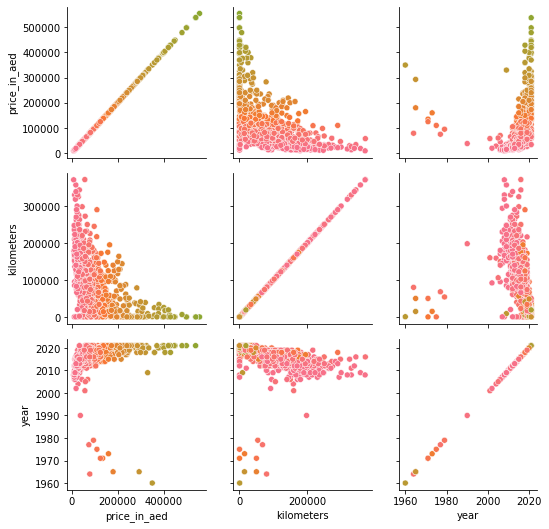

In [5]:
x = sns.PairGrid(dados, hue='precoFaixa', height=2.5)
x.map(sns.scatterplot)
# Cada cor de bolinhas nesse grafico é uma faixa de preço


### Preço x Marca

<AxesSubplot:xlabel='company', ylabel='price_in_aed'>

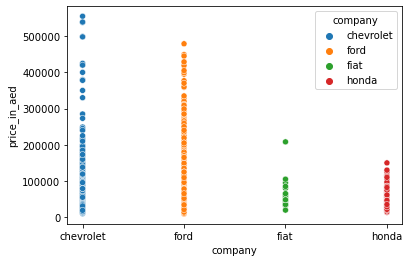

In [6]:
sns.scatterplot(data=dados, x="company", y=preco, hue= dados['company'])

In [7]:
# preco.to_frame()
pd.crosstab(preco, dados['company'])

company,chevrolet,fiat,ford,honda
price_in_aed,,,,
9000.0,0,0,1,0
9900.0,1,0,0,0
11000.0,0,0,1,0
11800.0,0,0,1,0
11900.0,0,0,1,0
...,...,...,...,...
498000.0,1,0,0,0
499000.0,1,0,0,0
538000.0,1,0,0,0


In [8]:
companhiaPreco = dados.groupby(dados['company'])['price_in_aed'].describe()
companhiaPreco

,count,mean,std,min,25%,50%,75%,max
company,,,,,,,,
chevrolet,290.0,98108.396552,95089.660844,9900.0,36600.0,71000.0,119000.0,555000.0
fiat,17.0,65658.823529,43632.643440,19500.0,38000.0,55000.0,80000.0,208000.0
ford,550.0,103992.567273,92761.744540,9000.0,37125.0,68500.0,139750.0,479000.0
honda,157.0,53497.299363,26487.153763,13500.0,31500.0,50000.0,69500.0,149999.0


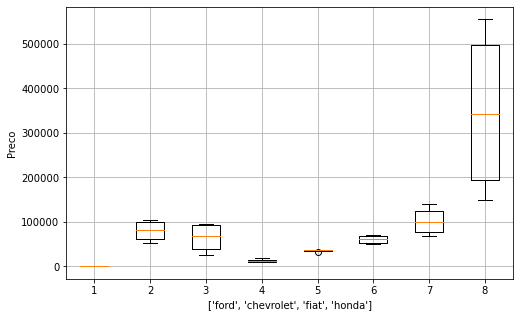

In [9]:
plt.figure(figsize=(8,5))
plt.boxplot(companhiaPreco)
plt.xlabel(marcas)
plt.ylabel('Preco')
plt.grid()
plt.show()

----
### Preço x Condição

In [10]:
corpoPreco = dados.groupby(dados['body_condition'])['price_in_aed'].describe()
corpoPreco

,count,mean,std,min,25%,50%,75%,max
body_condition,,,,,,,,
"A bit of wear & tear, all repaired",20.0,44685.000000,25145.267944,9000.0,31500.0,38850.0,58500.0,120000.0
"No accidents, very few faults",32.0,60381.093750,49077.618770,11000.0,25000.0,49500.0,79000.0,225000.0
"Normal wear & tear, a few issues",3.0,59666.666667,15011.106999,45000.0,52000.0,59000.0,67000.0,75000.0
Perfect inside and out,959.0,96097.735141,89234.663835,9900.0,37000.0,65000.0,119000.0,555000.0


In [11]:
bodytype = []
for tipo in dados['body_condition']:
    if tipo not in bodytype:
        bodytype.append(tipo)
len(bodytype)

4

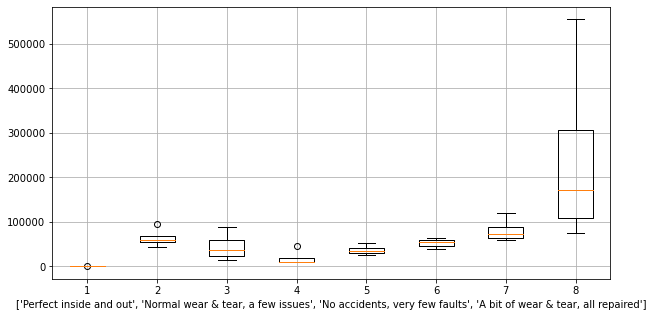

In [12]:
cor = ['r','b','g','m']
plt.figure(figsize=(10,5))
plt.boxplot(corpoPreco)
plt.xlabel(bodytype)
plt.grid()
plt.show()

----
### Preço x Tipo

In [13]:
dados.groupby(dados['body_type'])['price_in_aed'].describe()

,count,mean,std,min,25%,50%,75%,max
body_type,,,,,,,,
Coupe,108.0,102899.981481,94017.801138,23000.0,50000.00,69000.0,121125.0,555000.0
Crossover,13.0,70492.307692,49666.898124,27500.0,46000.00,59900.0,65500.0,195000.0
Hard Top Convertible,17.0,236870.529412,172240.024573,19500.0,110000.00,185000.0,350000.0,539000.0
Hatchback,54.0,38024.055556,24284.203559,11800.0,19624.75,34000.0,48000.0,135000.0
Other,19.0,125526.315789,59261.771846,48500.0,73750.00,115000.0,160000.0,250000.0
Pick Up Truck,143.0,162690.587413,105535.792478,15000.0,83950.00,139990.0,209950.0,479000.0
SUV,380.0,84599.439474,73820.265533,11000.0,34750.00,58000.0,99950.0,359000.0
Sedan,170.0,40252.858824,20318.160275,9000.0,25000.00,36949.5,52750.0,128900.0
Soft Top Convertible,21.0,102476.190476,69702.488512,13000.0,62000.00,77500.0,120000.0,293000.0


----
### Preço x Tipo de Transmissão

In [14]:
dados.groupby(dados['transmission_type'])['price_in_aed'].describe()

,count,mean,std,min,25%,50%,75%,max
transmission_type,,,,,,,,
Automatic Transmission,968.0,94206.429752,88419.087002,9000.0,36000.0,64000.0,117625.0,555000.0
Manual Transmission,46.0,86321.717391,73844.354769,15000.0,38250.0,63000.0,93750.0,350000.0


----
### Preço x Cavalos

In [15]:
dados.groupby(dados['horsepower'])['price_in_aed'].describe()

,count,mean,std,min,25%,50%,75%,max
horsepower,,,,,,,,
150 - 200 HP,164.0,47388.317073,28317.351933,11800.0,26900.0,39000.0,59925.00,208000.0
200 - 300 HP,248.0,69795.298387,62353.517630,11000.0,33000.0,48950.0,78000.00,350000.0
300 - 400 HP,255.0,100922.843137,67830.146590,14000.0,52500.0,84000.0,133666.50,325000.0
400 - 500 HP,154.0,178566.792208,121485.570220,21500.0,94500.0,139500.0,232500.00,555000.0
500 - 600 HP,24.0,196374.958333,130143.990115,9000.0,98000.0,166000.0,256750.00,429000.0
600 - 700 HP,5.0,202900.000000,84364.091887,95500.0,179000.0,195000.0,215000.00,330000.0
700 - 800 HP,7.0,326128.571429,57997.261840,239000.0,291000.0,319900.0,368500.00,405000.0
900+ HP,1.0,38500.000000,NaN,38500.0,38500.0,38500.0,38500.00,38500.0
Less than 150 HP,60.0,39131.616667,20199.206490,9900.0,23575.0,33450.0,52474.25,85000.0


----
### Preço x Ano

In [16]:
dados.groupby(dados['year'])['price_in_aed'].describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
1960.0,1.0,350000.000000,NaN,350000.0,350000.00,350000.0,350000.0,350000.0
1964.0,1.0,78999.000000,NaN,78999.0,78999.00,78999.0,78999.0,78999.0
1965.0,2.0,236500.000000,79903.066274,180000.0,208250.00,236500.0,264750.0,293000.0
1971.0,2.0,130000.000000,7071.067812,125000.0,127500.00,130000.0,132500.0,135000.0
1973.0,1.0,160000.000000,NaN,160000.0,160000.00,160000.0,160000.0,160000.0
1975.0,1.0,110000.000000,NaN,110000.0,110000.00,110000.0,110000.0,110000.0
1977.0,1.0,75000.000000,NaN,75000.0,75000.00,75000.0,75000.0,75000.0
1979.0,1.0,95000.000000,NaN,95000.0,95000.00,95000.0,95000.0,95000.0
1990.0,1.0,38000.000000,NaN,38000.0,38000.00,38000.0,38000.0,38000.0


----
### Preço x Km

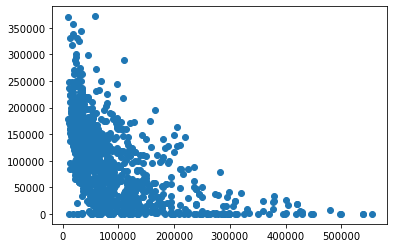

In [17]:
# sns.scatterplot(data=dados, x="company", y=preco, hue= dados['company'])

plt.scatter(dados['price_in_aed'],dados['kilometers'])
plt.show()

In [18]:
#anoQuilometragem = dados.kilometers.corr(dados.year)

precoQuilometragem = preco.corr(dados.kilometers)
print(precoQuilometragem)


-0.5478074901863463


----
### Preço x Combustivo

In [19]:
dados.groupby(dados['fuel_type'])['price_in_aed'].describe()

,count,mean,std,min,25%,50%,75%,max
fuel_type,,,,,,,,
Diesel,11.0,114863.636364,109609.098826,15000.0,50500.0,77500.0,119000.0,399000.0
Electric,1.0,135000.000000,NaN,135000.0,135000.0,135000.0,135000.0,135000.0
Gasoline,1000.0,93455.623000,87494.192379,9000.0,36000.0,64000.0,115000.0,555000.0
Hybrid,2.0,154250.000000,162281.006282,39500.0,96875.0,154250.0,211625.0,269000.0


In [25]:
dados.head(1)

,title,price_in_aed,kilometers,body_condition,mechanical_condition,body_type,transmission_type,horsepower,fuel_type,year,company,date_posted,precoFaixa
1,chevrolet silverado,110000.0,39000,Perfect inside and out,Perfect inside and out,SUV,Automatic Transmission,400 - 500 HP,Gasoline,2018.0,chevrolet,14/01/2022,"(105757.576, 125909.091]"


Predição pela Média

In [109]:
def calcula_preco(companhia, condicaoCorpo, condicaoMecanica,corpo, transmissao, cavalos, combustivel):

    filtradoComp = dados.loc[dados['company'] == str(companhia),:]
    filtradoCorp = filtradoComp.loc[dados['body_condition'] == str(condicaoCorpo),:]
    filtradoMec = filtradoComp.loc[dados['mechanical_condition'] == str(condicaoMecanica),:]
    filtradoCorpo = filtradoComp.loc[dados['body_type'] == str(corpo),:]
    filtradoTran = filtradoComp.loc[dados['transmission_type'] == str(transmissao),:]
    filtradoCav = filtradoComp.loc[dados['horsepower'] == str(cavalos),:]
    filtradoGas = filtradoComp.loc[dados['fuel_type'] == str(combustivel),:]

    estimado = filtradoComp['price_in_aed'].mean() + filtradoCorp['price_in_aed'].mean() + filtradoMec['price_in_aed'].mean() + filtradoCorpo['price_in_aed'].mean() + filtradoTran['price_in_aed'].mean() + filtradoCav['price_in_aed'].mean() + filtradoGas['price_in_aed'].mean()
    
    return 'O preço estimado para o veículo com estas especificações, seria de aproximadamente {:.2f} dolares'.format(estimado/7)
    
    
print(calcula_preco('chevrolet','Perfect inside and out','Perfect inside and out','SUV','Automatic Transmission','400 - 500 HP','Gasoline'))

     

O preço estimado para o veículo com estas especificações, seria de aproximadamente 109659.70 dolares
